Made by Yoonsoo P. Bach

# Cross-Sectional Area Calculation
In this notebook, I will record how to produce the cross-sectional area plot as a function of body-fixed coordinates, $(\theta_\mathrm{bf},\, \phi_\mathrm{bf})$.

## Preparation
1. You need to download and install ParaView (we tested using **ParaView 5.6.0**: [Download link](https://www.paraview.org/download/)).
2. You need the ``.obj`` file which defines the shape model. Download a shape model you want to use from [here](https://echo.jpl.nasa.gov/asteroids/shapes/shapes.html). We used ``4179 Toutatis high-resolution`` ([link](https://echo.jpl.nasa.gov/asteroids/shapes/hirestoutatis.obj)).
3. You will need to change some parameters in the codes shown below (I put comments at appropriate places). If not, it will not work.
4. You will need about **6.5 GB** of free space in your disk to save all the png files (I know it is a stupid approach, but this at least worked... If you have any better idea, please let me know and I may utilize that idea ;) )
5. Although these should be OS independent, the codes below are tested on macOS 10.14.2, MacBook Pro 15-inch 2018, 2.6 GHz 6-core i7, RAM 16GB 2400 MHz DDR4, Radeon Pro 560X 4096 MB.

### Testing Environment

In [1]:
%load_ext version_information
import time
now = time.strftime("%Y-%d-%m %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")
print("="*80)

vv = %version_information scipy, numpy, PIL, matplotlib, pandas, version_information
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

This notebook was generated at 2019-17-01 16:30:01 (KST = GMT+0900) 
0 Python     3.6.7 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
1 IPython    6.5.0
2 OS         Darwin 18.2.0 x86_64 i386 64bit
3 scipy      1.1.0
4 numpy      1.15.4
5 PIL        5.3.0
6 matplotlib 3.0.1
7 pandas     0.23.4
8 version_information 1.0.3


## Code for ParaView
Now, save the following code as ``pv_saver.py``:

* **IMPORTANT**: Set ``workdir``(the path where you will save the image files of Toutatis) and ``obj``(the path to the shape model, i.e., ``.obj`` file) properly depending on your system.
-----
```python
# Save as pv_saver.py at a certain directory
from paraview.simple import *
import numpy as np

def R():
    Render()

def ResetSession():
    pxm = servermanager.ProxyManager()
    pxm.UnRegisterProxies()
    del pxm
    Disconnect() 
    Connect()

thetas = np.deg2rad(np.arange(0., 180, 1))
phis = np.deg2rad(np.arange(0., 360, 1))

# ParaView 5.6.0
# Turn off "Orientation Axes".
workdir = "/Users/ysbach/Documents/Toutatis_temp/"  # !!!! Put your own directory here
obj = OpenDataFile(workdir + "Toutatis_highres.obj")
Show()
view = GetActiveView()
camera = view.GetActiveCamera()

#position camera
camera.ParallelProjectionOn()

# Set scale
view.CameraParallelScale = 2.5  # 0.5 * real height you want to use.
# e.g., 2.5 means I want to set the height = 5 [km or m depending on the obj file]
# This is meaningful only if ParallelProjectionOn().
view.Background = [0, 0, 0]  # black
view.ViewSize = [500, 500] #[width, height]

R()

for th in thetas:
    for ph in phis:
        thdeg = np.rad2deg(th)
        phdeg = np.rad2deg(ph)
        imgname = "Toutatis_{:03.0f}_{:03.0f}.png".format(thdeg, phdeg)
        r = 10
        x = r * np.sin(th) * np.cos(ph)
        y = r * np.sin(th) * np.sin(ph)
        z = r * np.cos(th)
        print(x, y, z)
        view.CameraPosition = [x, y, z]
        # Such that pixel = 10m * 10m
        dp = GetDisplayProperties()
        dp.Representation = "Surface"

        R()
        WriteImage(workdir + imgname)
```
-----

## Shape Rendering

Now turn on ParaView. 
1. Click ``View`` - ``Python Shell``.
2. On the python shell appeared, type ``from paraview.simple import *``.
3. At the icon panel, click on ``Show/Hide orientation axes``, so that the ``XYZ`` guide at the bottom left corner of the viewer disappears.
4. If you want to run the code above (**This took ~ 30 minutes on my MacBook Pro**), you can click ``Run Script`` and open the ``pv_saver.py`` saved above.

![](figs/paraview_01.png)

If you just want to test (you can play with the shape model), you may just copy-and-paste the first half part of ``pv_saver.py``:

-----
```python
from paraview.simple import *

def R():
    Render()

thetas = np.deg2rad(np.arange(0., 180, 1))
phis = np.deg2rad(np.arange(0., 360, 1))

# ParaView 5.6.0
# Turn off "Orientation Axes".
workdir = "/Users/ysbach/Documents/Toutatis_temp/"  # !!!! Put your own directory here
obj = OpenDataFile(workdir + "Toutatis_highres.obj")
Show()
view = GetActiveView()
camera = view.GetActiveCamera()

#position camera
camera.ParallelProjectionOn()
R()
```
-----
We need to turn the ``ParallelProjection`` on, because if not, the finite distance to the camera from the object may distort the shape of Toutatis, unlike our astronomical observation.

If you are ready, follow the 4th stepm described above. You will have 64,800 images saved to the ``workdir`` you specified. Each image has varying size but mostly ~ 0.05 MB. The name convention is ``Toutatis_<body_fixed_theta>_<body_fixed_phi>.png``, where body fixed coordinates are in degrees unit.

## Cross-Sectional Area Calculation
From the code above, each pixel corresponds to 10 m by 10 m, i.e., area of 100 square meters. Thus, if we cound the number of pixels with non-zero values, that will be the the total projected cross-sectional area / 100 square meter. Thus, you may use the following code to calculate all the cross-sectional areas.

* **IMPORTANT**: please modify the paths in the code below to meet your computer's condition!

``` python
# WARNING
# It takes tens of minutes to hours!!! Run only if it is really necessary.
from pathlib import Path
from PIL import Image
import numpy as np
import pandas as pd

# =============================================================================
# Modify here depending on your computer system
TOPPATH = Path("/") / "Users" / "ysbach" / "Documents" / "Toutatis_temp"
csvpath = TOPPATH / "all_cross_sections.csv"
simulpath = TOPPATH / "all_offset_simulation.csv"
# =============================================================================

allpngs = list(Path(TOPPATH).glob("*.png"))
cross_sections = dict(theta=[], phi=[], area=[])

for fpath in allpngs:
    _, th, ph = fpath.stem.split('_')
    img = np.array(Image.open(fpath).convert("L"))  # Convert to grayscale
    area_km2 = np.count_nonzero(img) / 10000  
    # each pixel = 10 m * 10 m. See pv_saver.py
    cross_sections["theta"].append(th)
    cross_sections["phi"].append(ph)
    cross_sections["area"].append(area_km2)

df = pd.DataFrame.from_dict(cross_sections)
df = df.sort_values(by=["theta", "phi"])
df.to_csv(csvpath, index=False)
```

As the comment says, it takes a lot of time. Please run it only when you really have to...

## Projected Area Plot
Consider the observer is at a distance of $ \infty $ to the direction of $ (\theta_\mathrm{bf},\, \phi_\mathrm{bf}) $. The projected area viewed by that observer is nothing but the ``area`` value for a given ``theta`` and ``phi`` in the csv file we saved above.

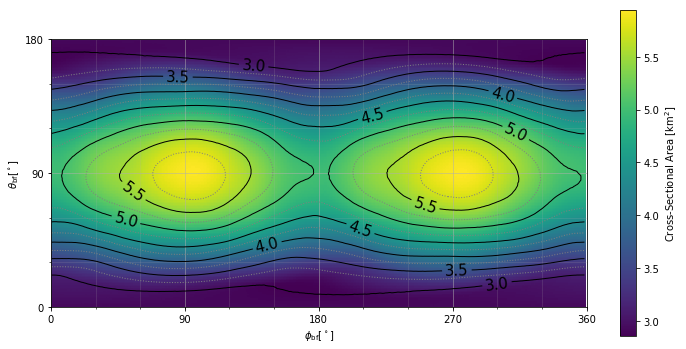

In [4]:
from pathlib import Path
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
# =============================================================================
# Modify here depending on your computer system
TOPPATH = Path("/") / "Users" / "ysbach" / "Documents" / "Toutatis_temp"
csvpath = TOPPATH / "all_cross_sections.csv"
simulpath = TOPPATH / "all_offset_simulation.csv"
# =============================================================================
df = pd.read_csv(csvpath)
df = df.sort_values(by=["theta", "phi"])

# =============================================================================
# Cross-Sectional Area as a function of body-fixed coordinate.
# For ex, value at th=1 and ph=1 means the projected area if the observer
# is at infinite distance to the direction of (th, ph)_bf = (1, 1) deg.
# =============================================================================
th = np.arange(0.1, 180, 1)
ph = np.arange(0.1, 360, 1)
area = np.array(df["area"]).reshape(180,360)
major_levels = np.arange(2, 7, 0.5)
minor_levels = np.arange(2.25, 7, 0.5)
extent = [ph.min(), ph.max(), th.min(), th.max()]

fig, ax = plt.subplots(figsize=(12,6))

cf = ax.imshow(area, cmap='viridis', extent=extent)
ax.set_xlabel(r"$\phi_\mathrm{bf} [^\circ]$")
ax.set_ylabel(r"$\theta_\mathrm{bf} [^\circ]$")

major_ticks = np.arange(0, 361, 90)
minor_ticks = np.arange(0, 361, 30)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

ax.set_xlim(0, 360)
ax.set_ylim(0, 180)
#plt.contourf(th, ph, area)
cs2 = plt.contour(area, levels=minor_levels, origin='lower', colors='gray',
                  extent=extent, linewidths=1, linestyles=':')
cs1 = plt.contour(area, levels=major_levels, origin='lower', colors='k',
                  extent=extent, linewidths=1)
ax.clabel(cs1, cs1.levels, inline=True, fontsize=15, fmt="%.1f")
plt.colorbar(cf, label=r"Cross-Sectional Area [km$^2$]")
plt.show()

## Smallest Cross-Sectional Area Too Small?
You may wonder why the smallest area is smaller than the area of a circle with 1 km radius. The shape of toutatis is known as something like 2km * 2km * 5km, so the smallest cross sectional area should be something like 4 $ \mathrm{km^2} $. 
As can be seen from below, the cross-sectional area viewed from $ (\theta_\mathrm{bf},\, \phi_\mathrm{bf}) = (179^\circ, \, 359^\circ) $ is definitely smaller than $ \pi \times (1 \,\mathrm{km})^2 = 3.142 \,\mathrm{km^2} $.

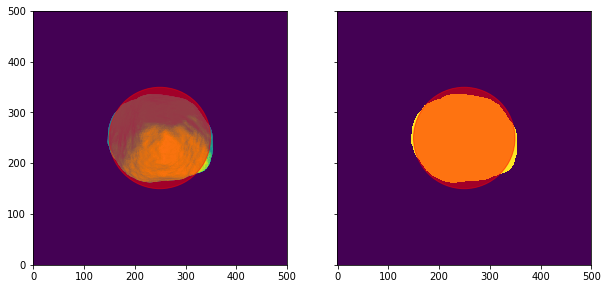

In [3]:
# =============================================================================
# Test: Should have dimension of ~ 1.92 * 2.29 km at smallest view, so the total
#   area should be something similar to a circle with radius 1 km.
#   But the smallest area in the next block is < 3 km^2, so I wanted to test
#   whether that visually makes sense.
# =============================================================================
from PIL import Image

testimgpath = TOPPATH / "Toutatis_179_359.png"
th = 179
ph = 359
rad = 100  # 1 pix = 10 m (see pv_saver.py)
testimg = np.array(Image.open(testimgpath).convert("L"))
nonzero = testimg > 0

fig, axs = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10, 5))
axs[0].imshow(testimg, origin='lower')
axs[0].add_artist(plt.Circle((249.5, 249.5), rad, color='r', alpha=0.5))

axs[1].imshow(nonzero, origin='lower')
axs[1].add_artist(plt.Circle((249.5, 249.5), rad, color='r', alpha=0.5))
plt.show()

# Absolutely smaller than the circle of 1 km...!!!